In [48]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [49]:
my_dir = './tabelas/'
files = os.listdir(my_dir)
dflst = []
for f in files:
    x = pd.read_csv(f'{my_dir}/{f}',index_col=0)
    dflst.append(x)

In [50]:
X = pd.concat(dflst)
X['data'] = pd.to_datetime(X['data'])

In [51]:
# todas as mercadorias
X['Mercadoria'].unique()

array(['B40 - Global 2040', 'BGI - Boi gordo', 'CCM - Milho',
       'DAP - Cupom de DI x IPCA', 'DDI - Cupom cambial',
       'DI1 - DI de 1 dia', 'DOL - Dólar comercial',
       'EUR - Euro (em Reais)', 'FRC - FRA de cupom', 'IAP - IPCA',
       'ICF - Café Arábica 4/5', 'IGM - IGP-M', 'IND - Ibovespa',
       'T10 - US T-Note 10 anos', 'WDL - Dólar comercial Mini',
       'WIN - Ibovespa Mini', 'ETH - Etanol Hidratado',
       'GBP - Libra Esterlina (em Reais)',
       'AUD - Dólar Australiano (em Reais)',
       'MXN - Peso Mexicano (em Reais)', 'JPY - Iene Japonês (em Reais)',
       'CAD - Dólar Canadense (em Reais)',
       'BRI - Futuro do Índice Brasil 50', 'SFI - Soja Financeira',
       'B20 - Global 2020', 'ZAR - Rande da África do Sul (em Reais)',
       'CHF - Franco Suíço (em Reais)', 'TRY - Lira Turca (em Reais)',
       'CLP - Peso Chileno (em Reais)',
       'CNY - Iuan Chinês Onshore (em Reais)',
       'NZD - Dólar da Nova Zelândia (em Reais)',
       'WDO - Dólar M

In [52]:
future_dictionary = {'01':'F',
'02':'G',
'03':'H',
'04':'J',
'05':'K',
'06':'M',
'07':'N',
'08':'Q',
'09':'U',
'10':'V',
'11':'X',
'12':'Z',}

future_dictionary_reversed = {v:k for k, v in future_dictionary.items()}

In [53]:
def GetTimeSeries(mercadoria,dias_ate_contrato ,data_set = X):
    df_mercadoria = data_set[data_set['Mercadoria'] == mercadoria].copy()
    if mercadoria == 'DI1 - DI de 1 dia':
        df_mercadoria = df_mercadoria[df_mercadoria['Vencimento'].str[0] == 'F'].copy()
    df_mercadoria['datetime_vecimento'] = pd.to_datetime('20'+df_mercadoria['Vencimento'].str[1:] +'-'+ df_mercadoria['Vencimento'].str[0].map(future_dictionary_reversed))
    df_mercadoria['time_left_vencimento'] = (df_mercadoria['datetime_vecimento']  - df_mercadoria['data'] ).apply(lambda row: row.days)
    df_mercadoria['Preço de ajuste Atual'] = pd.to_numeric(df_mercadoria['Preço de ajuste Atual'].str.replace('.','',regex=False).str.replace(',','.'))
    df_mercadoria['Preço de ajuste anterior'] = pd.to_numeric(df_mercadoria['Preço de ajuste anterior'].str.replace('.','',regex=False).str.replace(',','.'))
    df_mercadoria['Valor do ajuste por contrato (R$)'] = pd.to_numeric(df_mercadoria['Valor do ajuste por contrato (R$)'].str.replace('.','',regex=False).str.replace(',','.'))
    df_mercadoria['Variação'] = pd.to_numeric(df_mercadoria['Variação'].str.replace('.','',regex=False).str.replace(',','.'))

    df_mercadoria = df_mercadoria[df_mercadoria['time_left_vencimento'] >= 0].copy()
    preco_vencimento = pd.pivot_table(df_mercadoria,index='data', columns='Vencimento',values='Preço de ajuste Atual',aggfunc='first')
    preco_vencimento.sort_index(inplace=True)
    df_mercadoria['ordem_contrato'] = abs(df_mercadoria['time_left_vencimento'] - dias_ate_contrato) # quantos dias no futuro vc qr pegar o contrato escolehr o mais proximo 

    datas = list(df_mercadoria['data'].unique())
    escolha_contrato = {}
    trocar_contrato = True
    for data in datas:
        if trocar_contrato == True:
            df_aux = df_mercadoria[df_mercadoria['data'] == data].copy()
            contrato_escolhido = df_aux.loc[df_aux['ordem_contrato'].idxmin()]['Vencimento']
            tempo_limite = df_aux.loc[df_aux['ordem_contrato'].idxmin()]['datetime_vecimento']
            escolha_contrato[data] =  contrato_escolhido
            trocar_contrato = False
        else:
            escolha_contrato[data] =  contrato_escolhido

        if data >= tempo_limite:
            trocar_contrato = True

    s = pd.Series(escolha_contrato)
    s.name = 'escolha_de_contrato'
    definicao = df_mercadoria.merge(s,left_on='data',right_index=True)
    final = definicao[definicao['Vencimento'] == definicao['escolha_de_contrato']].copy()
    final.set_index('data',inplace=True)
    final.sort_index(inplace=True)
    final['contrato_d_1'] =  final['escolha_de_contrato'].shift(1)
    final['fechamento_d_1'] =  final['Preço de ajuste Atual'].shift(1)
    final['contrato_d_1'] = final['contrato_d_1'].bfill()
    final['ajustar'] = final['escolha_de_contrato'] != final['contrato_d_1']
    final['variacao_indevida'] = np.where(final['ajustar'] == True, final['Preço de ajuste anterior'] - final['fechamento_d_1'],0)
    final['variacao_indevida_acumulada'] = final['variacao_indevida'].sort_index(ascending=False).cumsum().sort_index()
    if mercadoria != 'DI1 - DI de 1 dia':
        final['ajusted_prices'] = (final['Preço de ajuste Atual'] + final['variacao_indevida_acumulada'])
    else:
        final['ajusted_prices'] =  np.where(final['ajustar'] == False,(final['Preço de ajuste Atual'] + final['variacao_indevida_acumulada']),\
                                             (final['Preço de ajuste Atual'] + final['variacao_indevida_acumulada'] - final['variacao_indevida']))


    return final

In [54]:
dolar_ptax = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?stub=1&serid=38590&module=M',thousands='^')[2]
df_ptax = dolar_ptax.iloc[1:].copy()
df_ptax.columns = ['data','usdbrl_ptax']
df_ptax['data'] = pd.to_datetime(df_ptax['data'],format='%d/%m/%Y')
df_ptax.set_index('data',inplace=True)

df_ptax = df_ptax.sort_index()

df_ptax = df_ptax.loc['2010-01-01':].copy()
df_ptax['usdbrl_ptax'] = pd.to_numeric(df_ptax['usdbrl_ptax'].str.replace(',','.'))

In [55]:
dias_ate_contrato = 15
boizin = GetTimeSeries('BGI - Boi gordo',15)
milhozin = GetTimeSeries('CCM - Milho',15)
sojazin = GetTimeSeries('SJC - Soja Financeira Cross Listing',15)

sojazin = sojazin.join(df_ptax)

In [56]:
sojazin['Preço de ajuste Atual'] = sojazin['Preço de ajuste Atual'] * sojazin['usdbrl_ptax']
sojazin['ajusted_prices'] = sojazin['ajusted_prices'] * sojazin['usdbrl_ptax']

In [57]:
boizin = boizin[['Vencimento','ajusted_prices','Preço de ajuste Atual']].copy()
boizin.columns = [f'BGI_{c}'for c in boizin.columns]

milhozin = milhozin[['Vencimento','ajusted_prices','Preço de ajuste Atual']].copy()
milhozin.columns = [f'CCM_{c}'for c in milhozin.columns]

sojazin = sojazin[['Vencimento','ajusted_prices','Preço de ajuste Atual']].copy()
sojazin.columns = [f'SFI_{c}'for c in sojazin.columns]

<Axes: title={'center': 'Comparação de contrato ajustado de milho'}, xlabel='data'>

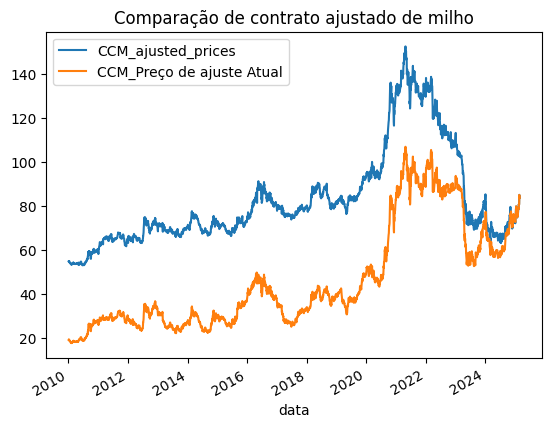

In [58]:
milhozin[['CCM_ajusted_prices','CCM_Preço de ajuste Atual']].plot(title='Comparação de contrato ajustado de milho')

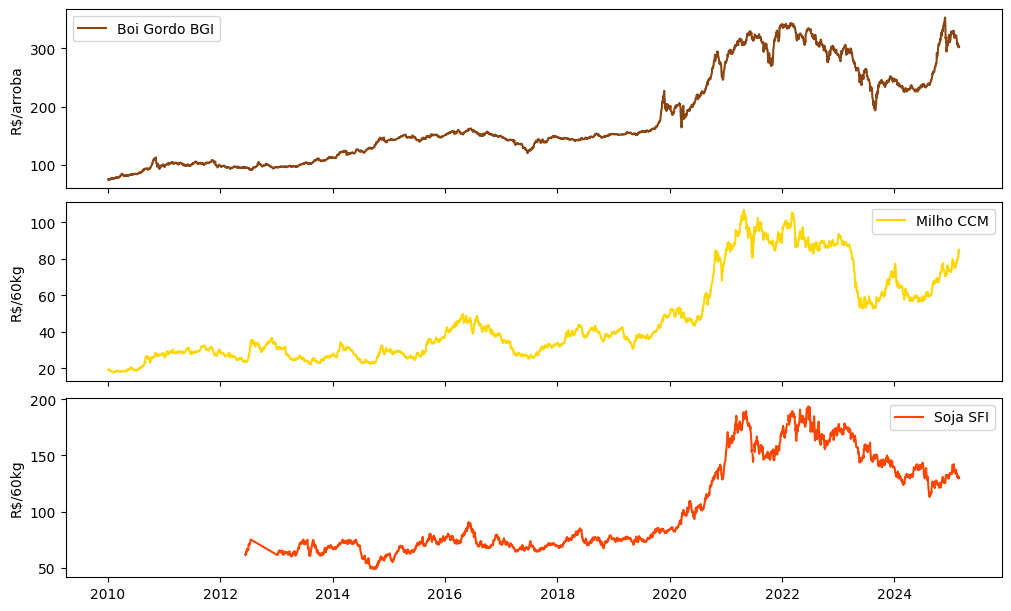

In [59]:
cor_marrom = "#8B4513"
cor_amarelo = "#FFD700"
cor_vermelho = "#FF4500"

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 6), constrained_layout=True)

# Plotando as séries temporais
axes[0].plot(boizin.index, boizin['BGI_Preço de ajuste Atual'], label='Boi Gordo BGI', color=cor_marrom)
axes[0].set_ylabel('R$/arroba')
axes[0].legend()

axes[1].plot(milhozin.index, milhozin['CCM_Preço de ajuste Atual'], label='Milho CCM', color=cor_amarelo)
axes[1].set_ylabel('R$/60kg')
axes[1].legend()

axes[2].plot(sojazin.index, sojazin['SFI_Preço de ajuste Atual'], label='Soja SFI', color=cor_vermelho)
axes[2].set_ylabel('R$/60kg')
axes[2].legend()


plt.show()

In [60]:
X_variaveis_correlacao_agro = pd.concat([boizin,milhozin,sojazin],axis=1)[['BGI_ajusted_prices','CCM_ajusted_prices','SFI_ajusted_prices']]

In [66]:
X_variaveis_correlacao_agro.dropna().diff().corr()

,BGI_ajusted_prices,CCM_ajusted_prices,SFI_ajusted_prices
BGI_ajusted_prices,1.000000,0.158693,0.047772
CCM_ajusted_prices,0.158693,1.000000,0.250613
SFI_ajusted_prices,0.047772,0.250613,1.000000
